In [32]:
import keras
from matplotlib import pyplot as pl
import numpy as np
import gzip
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.models import Model
from keras.optimizers import RMSprop
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
%matplotlib inline

In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

In [3]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

X_train = train_data.reshape(-1, 28,28, 1)  # add grey channel
X_test = test_data.reshape(-1, 28,28, 1)

n_classes = 10
Y_train = np_utils.to_categorical(train_labels, n_classes) # 1-hot
Y_test = np_utils.to_categorical(test_labels, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [4]:
# Shape of training set
print("Training set (images) shape: {shape}".format(shape=X_train.shape))
# Shape of test set
print("Test set (images) shape: {shape}".format(shape=X_test.shape))
# Type of data - should be float32
print('data type: ', X_train.dtype, X_test.dtype)

Training set (images) shape: (60000, 28, 28, 1)
Test set (images) shape: (10000, 28, 28, 1)
data type:  float32 float32


Text(0.5,1,'(Label: D)')

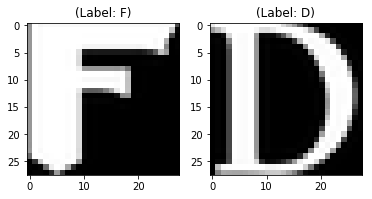

In [5]:
# Display the first image in training data
pl.subplot(121)
curr_img = np.reshape(X_train[0], (28,28))
curr_lbl = train_labels[0]
pl.imshow(curr_img, cmap='gray')
pl.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
pl.subplot(122)
curr_img = np.reshape(X_test[0], (28,28))
curr_lbl = test_labels[0]
pl.imshow(curr_img, cmap='gray')
pl.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [6]:
# rescale the data in range 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
cnn1 = Sequential()
cnn1.add(Conv2D(filters=32, kernel_size=4, input_shape=(28, 28, 1)))
cnn1.add(Activation('relu'))
cnn1.add(Conv2D(filters=32, kernel_size=3))
cnn1.add(Activation('relu'))
cnn1.add(MaxPooling2D(pool_size=2))
cnn1.add(Flatten())
cnn1.add(Dense(100, activation='relu'))
cnn1.add(Dense(n_classes, activation='softmax'))
cnn1.summary()

In [ ]:
cnn1.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
log = cnn1.fit(X_train, Y_train, batch_size=128, epochs=10,
                    verbose=1, validation_data=(X_test, Y_test))

In [ ]:
pl.plot(log.history['acc'], label='Training')
pl.plot(log.history['val_acc'], label='Testing')
pl.legend()
pl.grid()

In [ ]:
loss_test, metric_test = cnn1.evaluate(test_data, Y_test, verbose=1)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

## Shallow dense autoencoder

In [22]:
# size of our encoded representation
encoding_dim = 32

input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, 
                outputs=decoder_layer(encoded_input))

In [23]:
autoencoder.compile(optimizer='adadelta', 
                    loss='mean_squared_error')

In [24]:
# for visualiztion
def plot_result(x_test,decoded_imgs):
    n = 10
    pl.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = pl.subplot(2, n, i + 1)
        pl.imshow(x_test[i].reshape(28, 28))
        pl.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = pl.subplot(2, n, i + 1 + n)
        pl.imshow(decoded_imgs[i].reshape(28, 28))
        pl.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    pl.show()

In [28]:
X_train_flat = X_train.reshape(60000,784)
X_test_flat = X_test.reshape(10000,784)

In [29]:
log = autoencoder.fit(X_train_flat, X_train_flat,
                      epochs=50, batch_size=256,
                      shuffle=True,
                      validation_data=(X_test_flat, X_test_flat))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 15us/step - loss: 0.2034 - val_loss: 0.1900
Epoch 2/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1766 - val_loss: 0.1635
Epoch 3/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1533 - val_loss: 0.1404
Epoch 4/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1327 - val_loss: 0.1190
Epoch 5/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1160 - val_loss: 0.1042
Epoch 6/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.1054 - val_loss: 0.0950
Epoch 7/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0979 - val_loss: 0.0879
Epoch 8/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0914 - val_loss: 0.0817
Epoch 9/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.0857 - val_loss: 0.0764
Epoch

In [ ]:
pl.plot(log.history['loss'], label='Training')
pl.plot(log.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

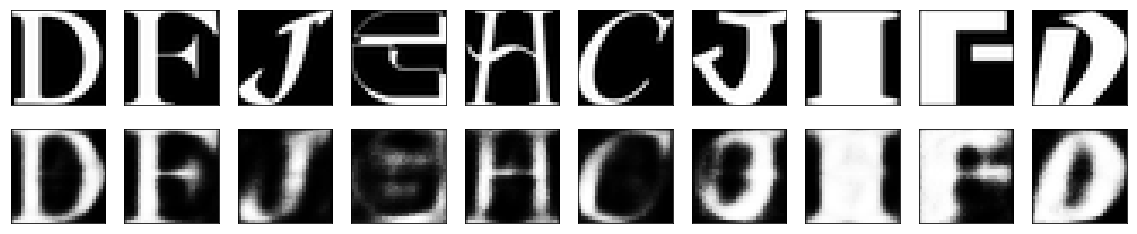

In [20]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test_flat)
decoded_imgs = decoder.predict(encoded_imgs)
plot_result(X_test_flat,decoded_imgs)

## Use the encoded features to train another classifier

In [33]:
X_train_feat = encoder.predict(X_train_flat)
X_test_feat = encoder.predict(X_test_flat)

# Normalization (standardization) of training and test sets
scaler = StandardScaler()  
scaler.fit(X_train_feat)
X_train_feat = scaler.transform(X_train_feat)  
X_test_feat = scaler.transform(X_test_feat)

print(X_train_feat.shape)
print(Y_train.shape)
print(X_test_feat.shape)
print(Y_test.shape)

(60000, 32)
(60000, 10)
(10000, 32)
(10000, 10)


In [57]:
# using the features
clf = SVC(kernel='linear', cache_size=7000)
clf.fit(X_train_feat, train_labels)

SVC(C=1.0, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [58]:
y_pred = clf.predict(X_test_feat)

# Print classification results with confusion matrix
print("Classification report for classifier %s:\n%s\n" %
      (clf, metrics.classification_report(test_labels, y_pred)))
# print("\nConfusion matrix:\n%s" % metrics.confusion_matrix(test_labels, y_pred))

Classification report for classifier SVC(C=1.0, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.90      0.90      0.90      1000
          1       0.90      0.87      0.88      1000
          2       0.90      0.92      0.91      1000
          3       0.92      0.90      0.91      1000
          4       0.89      0.87      0.88      1000
          5       0.90      0.94      0.92      1000
          6       0.88      0.88      0.88      1000
          7       0.92      0.89      0.90      1000
          8       0.89      0.86      0.88      1000
          9       0.85      0.94      0.89      1000

avg / total       0.90      0.89      0.89     10000




In [59]:
# using the pixels
clf_pixel = SVC(kernel='linear', cache_size=7000)
clf_pixel.fit(X_train_flat, train_labels)

SVC(C=1.0, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [56]:
y_pred_pixel = clf_pixel.predict(X_test_flat)

# Print classification results with confusion matrix
print("Classification report for classifier %s:\n%s\n" %
      (clf, metrics.classification_report(test_labels, y_pred_pixel)))

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.94      0.93      0.94      1000
          1       0.93      0.91      0.92      1000
          2       0.94      0.93      0.93      1000
          3       0.94      0.92      0.93      1000
          4       0.94      0.90      0.92      1000
          5       0.90      0.94      0.92      1000
          6       0.90      0.91      0.90      1000
          7       0.95      0.92      0.93      1000
          8       0.90      0.89      0.89      1000
          9       0.88      0.95      0.92      1000

avg / total       0.92      0.92      0.92     10000




## Conv autoencoder

In [42]:
input_img = Input(shape = (28, 28, 1))
# encoder
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
# decoder
conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
# autoencoder
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 7, 7, 128)         147584    
__________

In [43]:
log = autoencoder.fit(X_train, X_train, batch_size=128, epochs=1,
                        verbose=1, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 309s 5ms/step - loss: 0.0290 - val_loss: 0.0095


### Predict on test data

In [45]:
decoded_imgs = autoencoder.predict(X_test, verbose=1)
print(decoded_imgs.shape)

10000/10000 [==============================] - 11s 1ms/step
(10000, 28, 28, 1)


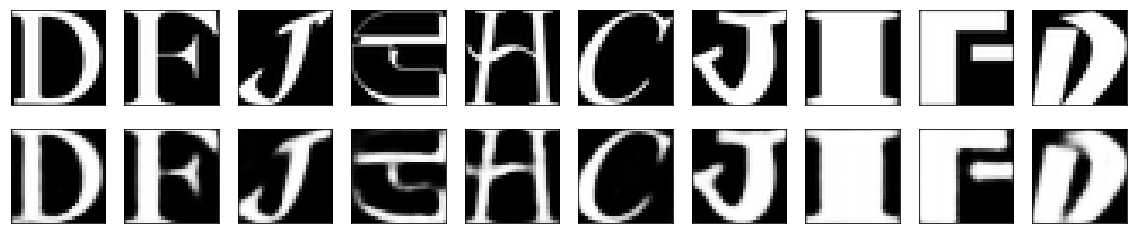

In [46]:
plot_result(X_test_flat,decoded_imgs)

## Denoising autoencoder
First add some noise.

In [47]:
noise_factor = 0.4
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

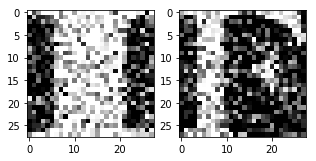

In [49]:
pl.figure(figsize=[5,5])

# Display the first image in training data
pl.subplot(121)
curr_img = np.reshape(X_train_noisy[1], (28,28))
pl.imshow(curr_img, cmap='gray')

# Display the first image in testing data
pl.subplot(122)
curr_img = np.reshape(X_test_noisy[1], (28,28))
pl.imshow(curr_img, cmap='gray')

In [50]:
input_img = Input(shape = (28, 28, 1))
# encoder
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
# decoder
conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
# autoencoder
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 7, 7, 128)         147584    
__________

In [51]:
log = autoencoder.fit(X_train_noisy, X_train, batch_size=128, epochs=1,
                        verbose=1, validation_data=(X_test_noisy, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 291s 5ms/step - loss: 0.0416 - val_loss: 0.0166


In [52]:
decoded_imgs = autoencoder.predict(X_test_noisy, verbose=1)
print(decoded_imgs.shape)

10000/10000 [==============================] - 11s 1ms/step
(10000, 28, 28, 1)


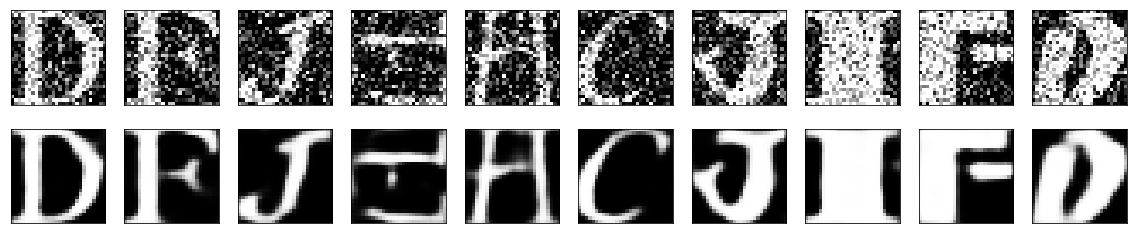

In [53]:
plot_result(X_test_noisy,decoded_imgs)